In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

df_confirmed = pd.read_csv(
    '../../corona/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv',
                sep=',',encoding='ISO8859-1')

df_deceased = pd.read_csv(
    '../../corona/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv',
                sep=',',encoding='ISO8859-1')


In [19]:
df_deceased

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,6/19/21,6/20/21,6/21/21,6/22/21,6/23/21,6/24/21,6/25/21,6/26/21,6/27/21,6/28/21
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,3934,3934,4215,4293,4366,4452,4519,4519,4519,4730
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,2454,2454,2454,2455,2455,2455,2455,2456,2456,2456
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,3624,3631,3641,3650,3660,3669,3678,3685,3693,3699
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,127,127,127,127,127,127,127,127,127,127
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,856,859,868,875,878,881,883,887,889,891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,NaN,Vietnam,14.058324,108.277199,0,0,0,0,0,0,...,64,66,69,69,70,72,74,74,76,78
275,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,3550,3551,3554,3555,3555,3555,3556,3556,3559,3561
276,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,1353,1355,1355,1355,1355,1356,1357,1358,1360,1361
277,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,1595,1644,1691,1744,1794,1855,1915,1967,2022,2091


In [20]:
### m UK count includes all their provinces

df_deceased[df_deceased['Country/Region'] == 'United Kingdom']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,6/19/21,6/20/21,6/21/21,6/22/21,6/23/21,6/24/21,6/25/21,6/26/21,6/27/21,6/28/21
258,Anguilla,United Kingdom,18.220600,-63.068600,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
259,Bermuda,United Kingdom,32.307800,-64.750500,0,0,0,0,0,0,...,33,33,33,33,33,33,33,33,33,33
260,British Virgin Islands,United Kingdom,18.420700,-64.640000,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
261,Cayman Islands,United Kingdom,19.313300,-81.254600,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
262,Channel Islands,United Kingdom,49.372300,-2.364400,0,0,0,0,0,0,...,86,86,86,86,86,86,86,86,86,86
263,Falkland Islands (Malvinas),United Kingdom,-51.796300,-59.523600,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
264,Gibraltar,United Kingdom,36.140800,-5.353600,0,0,0,0,0,0,...,94,94,94,94,94,94,94,94,94,94
265,Isle of Man,United Kingdom,54.236100,-4.548100,0,0,0,0,0,0,...,29,29,29,29,29,29,29,29,29,29
266,Montserrat,United Kingdom,16.742498,-62.187366,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
267,"Saint Helena, Ascension and Tristan da Cunha",United Kingdom,-7.946700,-14.355900,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
df_confirmed.tail(40)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,6/19/21,6/20/21,6/21/21,6/22/21,6/23/21,6/24/21,6/25/21,6/26/21,6/27/21,6/28/21
239,NaN,Sudan,12.862800,30.217600,0,0,0,0,0,0,...,36347,36347,36347,36347,36522,36558,36574,36574,36574,36620
240,NaN,Summer Olympics 2020,35.649100,139.773700,0,0,0,0,0,0,...,1,1,1,1,1,6,6,6,6,1
241,NaN,Suriname,3.919300,-56.027800,0,0,0,0,0,0,...,19748,20025,20141,20298,20549,20723,20911,21060,21249,21360
242,NaN,Sweden,60.128161,18.643501,0,0,0,0,0,0,...,1084636,1084636,1084636,1088014,1088518,1088896,1088896,1088896,1088896,1088896
243,NaN,Switzerland,46.818200,8.227500,0,0,0,0,0,0,...,701627,701627,701994,702124,702278,702398,702507,702507,702507,702746
244,NaN,Syria,34.802075,38.996815,0,0,0,0,0,0,...,25076,25118,25158,25205,25248,25287,25328,25365,25404,25442
245,NaN,Taiwan*,23.700000,121.000000,1,1,3,3,4,5,...,13896,14005,14080,14157,14260,14389,14465,14545,14634,14694
246,NaN,Tajikistan,38.861000,71.276100,0,0,0,0,0,0,...,13308,13308,13308,13308,13358,13358,13392,13415,13439,13460
247,NaN,Tanzania,-6.369028,34.888822,0,0,0,0,0,0,...,509,509,509,509,509,509,509,509,509,509
248,NaN,Thailand,15.870032,100.992541,4,4,5,6,8,8,...,214449,218131,221306,225365,228539,232647,236291,240452,244447,249853


In [22]:
countries = df_confirmed['Country/Region'].unique()
sorted(countries)

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burma',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Diamond Princess',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Grenada',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',

In [23]:

all_countries = pd.DataFrame()

for c in countries:
    temp = df_confirmed[df_confirmed['Country/Region'] == c]
    temp = temp.groupby('Country/Region')
    temp = temp.sum().iloc[:,4:]
    temp = temp.T

    all_countries = pd.concat([all_countries,temp],axis=1)

def create_country_df(country):
    
    confirmed = all_countries[country]
    confirmed.index = pd.to_datetime(confirmed.index)
    factor = confirmed / confirmed.shift()
    data = pd.concat([confirmed,factor],axis=1)
    data.columns = ['confirmed','factor']
    data.factor.replace(np.inf,np.nan,inplace=True)
    data['inc'] = data['confirmed'] - data['confirmed'].shift()
    return data

confirmed_dict = dict()

for c in countries:
    confirmed_dict[c] = create_country_df(c)
    
thai = confirmed_dict['Thailand']
swe = confirmed_dict['Sweden']
ita = confirmed_dict['Italy']
korea = confirmed_dict['Korea, South']
us = confirmed_dict['US']
spain = confirmed_dict['Spain']
ger = confirmed_dict['Germany']

ita


,confirmed,factor,inc
2020-01-24,0,NaN,NaN
2020-01-25,0,NaN,0.0
2020-01-26,0,NaN,0.0
2020-01-27,0,NaN,0.0
2020-01-28,0,NaN,0.0
...,...,...,...
2021-06-24,4255700,1.000063,266.0
2021-06-25,4256451,1.000176,751.0
2021-06-26,4257289,1.000197,838.0
2021-06-27,4258069,1.000183,780.0


In [24]:
global_confirmed = df_confirmed.iloc[:,5:].sum()


In [25]:
global_deceased = df_deceased.iloc[:,5:].sum()
global_deceased.index = pd.to_datetime(global_deceased.index)
global_confirmed = df_confirmed.iloc[:,5:].sum()
global_confirmed.index = pd.to_datetime(global_confirmed.index)

global_data = pd.DataFrame(global_confirmed,columns=['confirmed'])
global_data['factor'] = global_data['confirmed'] / global_data['confirmed'].shift()
global_data['inc'] = global_data['confirmed'] - global_data['confirmed'].shift()
global_data['dead'] = global_deceased
global_data['dead_factor'] = global_data['dead'] / global_data['dead'].shift()
global_data['dead_inc'] = global_data['dead'] - global_data['dead'].shift()
global_data['pct_dead'] = 100 * global_data['dead'] /global_data['confirmed']
global_data.index = pd.to_datetime(global_data.index)
global_data.to_pickle('global_data.pkl')
global_data
global_data.describe()

,confirmed,factor,inc,dead,dead_factor,dead_inc,pct_dead
count,5.230000e+02,522.000000,5.220000e+02,5.230000e+02,522.000000,522.000000,523.000000
mean,6.029352e+07,1.025969,3.475577e+05,1.453763e+06,1.025391,7528.147510,3.445519
std,5.878067e+07,0.066504,2.477686e+05,1.216434e+06,0.062230,4277.581452,1.588446
min,6.550000e+02,1.001666,2.860000e+02,1.800000e+01,1.001518,2.000000,2.040300
25%,6.345214e+06,1.005259,1.196732e+05,3.973875e+05,1.004287,5043.250000,2.245958
50%,3.727933e+07,1.010001,3.101075e+05,1.124285e+06,1.006705,6771.500000,2.671918
75%,1.101775e+08,1.018520,5.335782e+05,2.509179e+06,1.011523,10493.000000,4.119978
max,1.814258e+08,1.905706,1.498126e+06,3.929711e+06,1.615385,18050.000000,7.356650


/usr/local/lib64/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


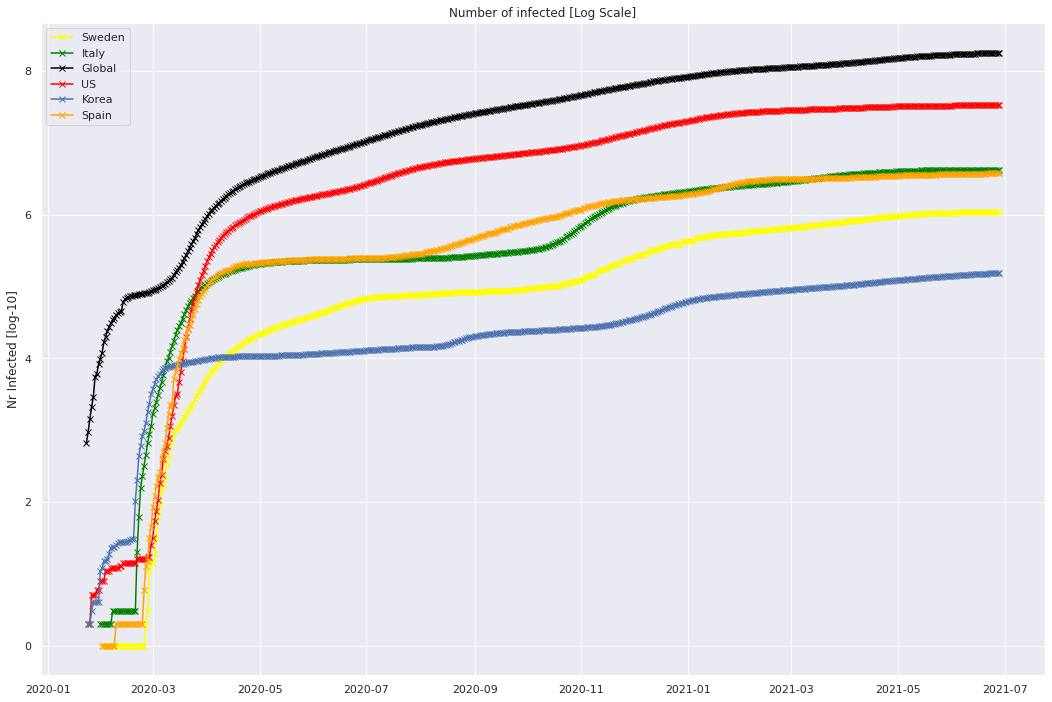

In [26]:
global_conf = np.log10(global_confirmed)

swe_conf = swe.loc[swe['confirmed'] > 0]
swe_conf = np.log10(swe_conf['confirmed'])
ita_conf = ita.loc[ita['confirmed'] > 0]
ita_conf = np.log10(ita_conf['confirmed'])
us_conf = us.loc[us['confirmed'] > 0]
us_conf = np.log10(us_conf['confirmed'])
korea_conf = korea.loc[korea['confirmed'] > 0]
korea_conf = np.log10(korea_conf['confirmed'])
spain_conf = spain.loc[spain['confirmed'] > 0]
spain_conf = np.log10(spain['confirmed'])

plt.figure(figsize=(18,12))
plt.title('Number of infected [Log Scale]')
plt.plot(swe_conf,'x-',color='yellow',label='Sweden')
plt.plot(ita_conf,'x-',color='green',label='Italy')
plt.plot(global_conf,'x-',color='black',label='Global')
plt.plot(us_conf,'x-',color='red',label='US')
plt.plot(korea_conf,'x-',color='b',label='Korea')
plt.plot(spain_conf,'x-',color='orange',label='Spain')
plt.ylabel('Nr Infected [log-10]')
plt.legend(loc='upper left')
plt.savefig('corona_evolution_countries_log.jpg',format='jpg')

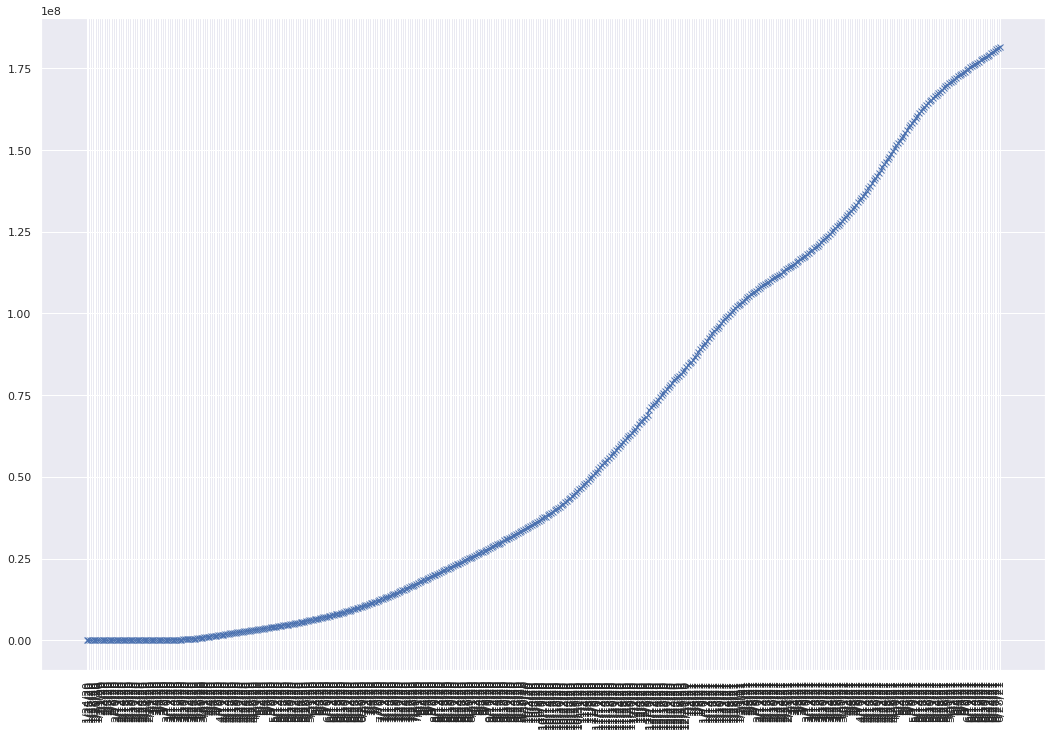

In [27]:
global_series = all_countries.sum(axis=1)
_= plt.figure(figsize=(18,12))
_= plt.plot(global_series,'x--')

_= plt.xticks(rotation=90)



In [28]:


countries_deceased = countries
all_countries_deceased = pd.DataFrame()

for c in countries_deceased:
    temp = df_deceased[df_deceased['Country/Region'] == c]
    temp = temp.groupby('Country/Region')
    temp = temp.sum().iloc[:,4:]
    temp = temp.T

    all_countries_deceased = pd.concat([all_countries_deceased,temp],axis=1)
    

def create_deceased_df(country):
    process = True
    try:
        deceased = all_countries_deceased[country]
    except KeyError:
        print ('cant find {} in deaths'.format(country))
        process = False
        
    if process:
        deceased.index = pd.to_datetime(deceased.index)
        factor = deceased / deceased.shift()

        data = pd.concat([deceased,factor],axis=1)
        data.columns = ['deceased','dead_factor']
        data.dead_factor.replace(np.inf,np.nan,inplace=True)
        data['dead_inc'] = data['deceased'] - data['deceased'].shift()
        return data

deceased_dict = dict()

for c in countries_deceased:
    
    deceased_dict[c] = create_deceased_df(c)




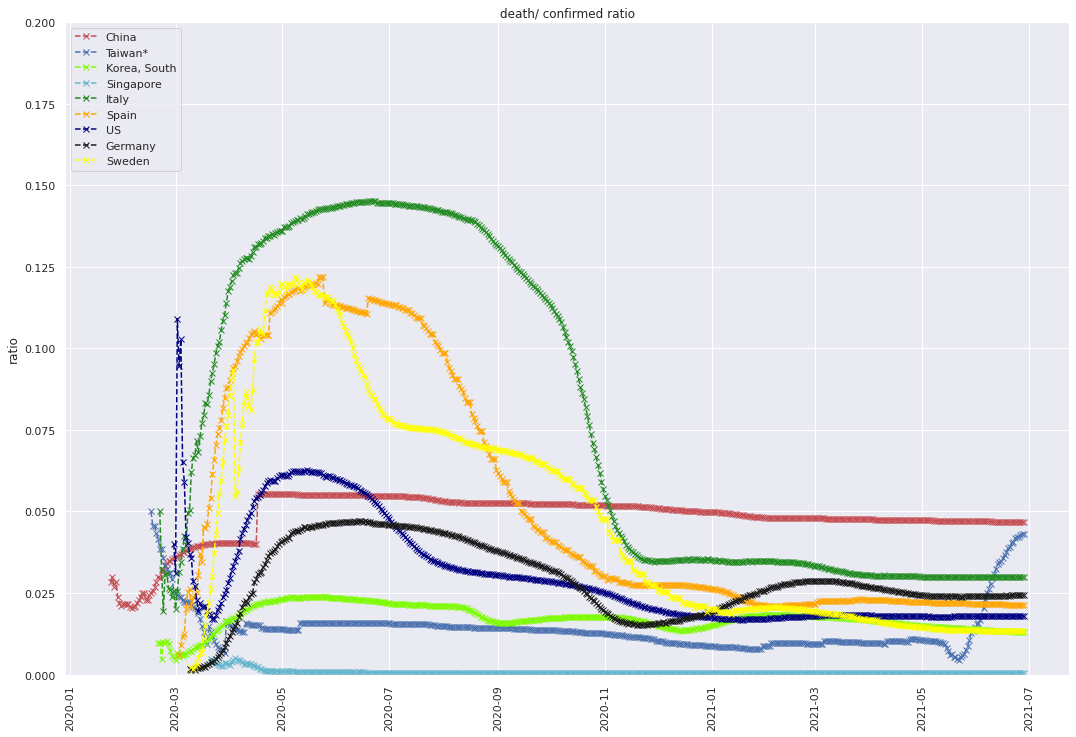

In [29]:
country_data = dict()

for c in countries:
    country_data[c] = pd.concat([confirmed_dict[c],deceased_dict[c]],axis=1)
    country_data[c]['pct_dead'] = 100 * country_data[c]['deceased'] / country_data[c]['confirmed']
    country_data[c]['conf_over_dead'] = country_data[c]['confirmed'] / country_data[c]['deceased']
    country_data[c]['conf_over_dead'] = country_data[c]['conf_over_dead'].replace(np.inf,np.nan)
    country_data[c]['dead_conf_ratio'] =  country_data[c]['dead_factor'] / country_data[c]['factor']
    

import pickle

with open ('country_data.pkl','wb') as f:
    pickle.dump(country_data,f,protocol=pickle.HIGHEST_PROTOCOL)

countries_of_interest = ['China','Taiwan*','Korea, South','Singapore',
                         'Italy','Spain','US','Germany','Sweden']

colors = ['r','b','lawngreen','c',
          'forestgreen','orange','navy','k','yellow']

plt.figure(figsize=(18,12))
plt.title('death/ confirmed ratio')

i = 0
for c in countries_of_interest:
    country = country_data[c]
    mask = country['deceased'] >= 1
    country = country[mask]
    plt.plot(country['deceased'] / country['confirmed'],'x--',
             color=colors[i],label=c)
    i += 1      

plt.ylabel('ratio')
plt.xticks(rotation=90)
plt.ylim([0,0.20])
plt.legend(loc='upper left')
#plt.yscale('log')

plt.savefig('corona_dead_conf_ratio.jpg',format='jpg')


In [30]:
country_data['Sweden'].tail(40)

,confirmed,factor,inc,deceased,dead_factor,dead_inc,pct_dead,conf_over_dead,dead_conf_ratio
2021-05-20,1055173,1.003243,3411.0,14351,1.000139,2.0,1.360061,73.526096,0.996906
2021-05-21,1058341,1.003002,3168.0,14366,1.001045,15.0,1.357407,73.669845,0.998049
2021-05-22,1058341,1.000000,0.0,14366,1.000000,0.0,1.357407,73.669845,1.000000
2021-05-23,1058341,1.000000,0.0,14366,1.000000,0.0,1.357407,73.669845,1.000000
2021-05-24,1058341,1.000000,0.0,14366,1.000000,0.0,1.357407,73.669845,1.000000
2021-05-25,1064375,1.005701,6034.0,14396,1.002088,30.0,1.352531,73.935468,0.996407
2021-05-26,1067107,1.002567,2732.0,14436,1.002779,40.0,1.352817,73.919853,1.000211
2021-05-27,1068473,1.001280,1366.0,14451,1.001039,15.0,1.352491,73.937651,0.999759
2021-05-28,1068473,1.000000,0.0,14451,1.000000,0.0,1.352491,73.937651,1.000000
2021-05-29,1068473,1.000000,0.0,14451,1.000000,0.0,1.352491,73.937651,1.000000


In [31]:
country_data['US'].tail(60)

,confirmed,factor,inc,deceased,dead_factor,dead_inc,pct_dead,conf_over_dead,dead_conf_ratio
2021-04-30,32350861,1.001794,57919.0,576332,1.001308,753.0,1.781504,56.132335,0.999516
2021-05-01,32396252,1.001403,45391.0,577047,1.001241,715.0,1.781215,56.141444,0.999838
2021-05-02,32425655,1.000908,29403.0,577383,1.000582,336.0,1.780636,56.159698,0.999675
2021-05-03,32476146,1.001557,50491.0,577887,1.000873,504.0,1.779420,56.198091,0.999317
2021-05-04,32516869,1.001254,40723.0,578762,1.001514,875.0,1.779882,56.183490,1.000260
2021-05-05,32561573,1.001375,44704.0,579556,1.001372,794.0,1.779877,56.183653,0.999997
2021-05-06,32609130,1.001461,47557.0,580355,1.001379,799.0,1.779732,56.188247,0.999918
2021-05-07,32657260,1.001476,48130.0,581114,1.001308,759.0,1.779433,56.197682,0.999832
2021-05-08,32690935,1.001031,33675.0,581743,1.001082,629.0,1.779524,56.194806,1.000051
2021-05-09,32712362,1.000655,21427.0,581992,1.000428,249.0,1.779119,56.207580,0.999773


In [32]:
country_data['Italy'].tail(40)

,confirmed,factor,inc,deceased,dead_factor,dead_inc,pct_dead,conf_over_dead,dead_conf_ratio
2021-05-20,4178261,1.001375,5736.0,124810,1.001316,164.0,2.987128,33.476973,0.999941
2021-05-21,4183476,1.001248,5215.0,125028,1.001747,218.0,2.988615,33.460313,1.000498
2021-05-22,4188190,1.001127,4714.0,125153,1.001000,125.0,2.988236,33.464559,0.999873
2021-05-23,4192183,1.000953,3993.0,125225,1.000575,72.0,2.987107,33.477205,0.999622
2021-05-24,4194672,1.000594,2489.0,125335,1.000878,110.0,2.987957,33.467683,1.000285
2021-05-25,4197892,1.000768,3220.0,125501,1.001324,166.0,2.989620,33.449072,1.000556
2021-05-26,4201827,1.000937,3935.0,125622,1.000964,121.0,2.989699,33.448178,1.000027
2021-05-27,4205970,1.000986,4143.0,125793,1.001361,171.0,2.990820,33.435644,1.000375
2021-05-28,4209707,1.000888,3737.0,125919,1.001002,126.0,2.991158,33.431865,1.000113
2021-05-29,4213055,1.000795,3348.0,126002,1.000659,83.0,2.990751,33.436414,0.999864


In [33]:
swe = country_data['Sweden']
tot_dead = (swe['dead_inc'].sum())
print (tot_dead)

dead_per_day = tot_dead / len(pd.date_range('2020-01-01','2020-05-21'))
print (dead_per_day)

swe[swe['confirmed'] > 1000].describe()

ita = country_data['Italy']

tot_dead_it = ita['dead_inc'].sum() 
print (tot_dead_it)
dead_per_day_it = tot_dead_it / len(pd.date_range('2020-01-01','2020-05-21'))
print (dead_per_day_it)

print (dead_per_day / 10) # dead per day per million swe
print (dead_per_day_it / 60)

14619.0
102.95070422535211
127500.0
897.887323943662
10.295070422535211
14.964788732394366


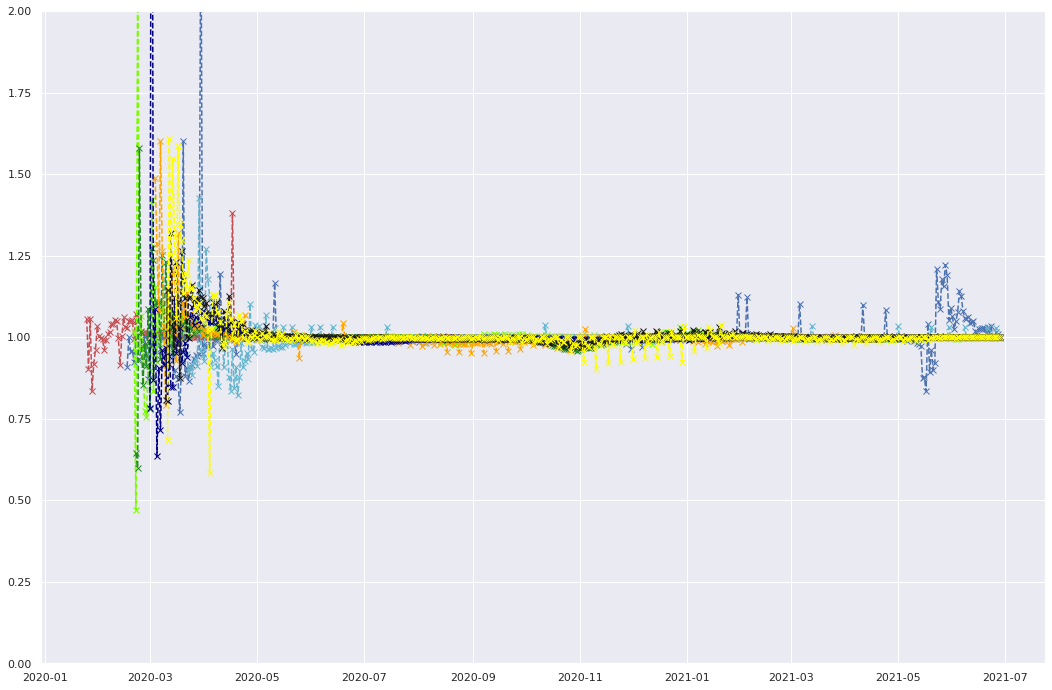

In [34]:
plt.figure(figsize=(18,12))
plt.ylim([0,2])
i = 0
for c in countries_of_interest:
    country = country_data[c]
    mask = country['deceased'] >= 1
    country = country[mask]
    plt.plot(country['dead_conf_ratio'],'x--',
             color=colors[i],label=c)
    i += 1 